# ENM User Interface Tool Documentation

Creators : Cam Cooper and Claudia Smith

Date: March 2020

## Outline

- Tool Use Overview
- Scripts Used / Architecture Overview
- MOBATCH vs. CLI Commands
- Adding New ENM Command to Tool
- Command Manipulation Specifics
- Challenges / Useful Remarks
- External Resources

## Tool Use Overview

**Test Version URL:** http://gascran.web.att.com:8080/apache-cgi/ENMScript.sh

**Live Version URL:** http://gascran.web.att.com:8080/apache-cgi/ENMScript_v2.sh

**Use Instructions:** Select the ENM market server associated with your eNodeB. Select the command group that you wish to run. Input the eNodeB that you wish to pull ENM results for. Enter your ATTID and RSA Soft Token Passcode into the corresponding input boxes, then click submit.

**Overview:** ENM User Interface Tool conatains a selection of ENM AMOS commands from which a user can run for a specified eNodeB. There are separate pages for the parameter viewing and parameter setting commands. To access the parameter writing commands, select the *Set ENM Parameters* Link (presented below). Or, the user may select a specific eNodeB from the results table (once populated) in order to write commands to that eNodeB.

*Below is a snapshhot of the tool landing page..*
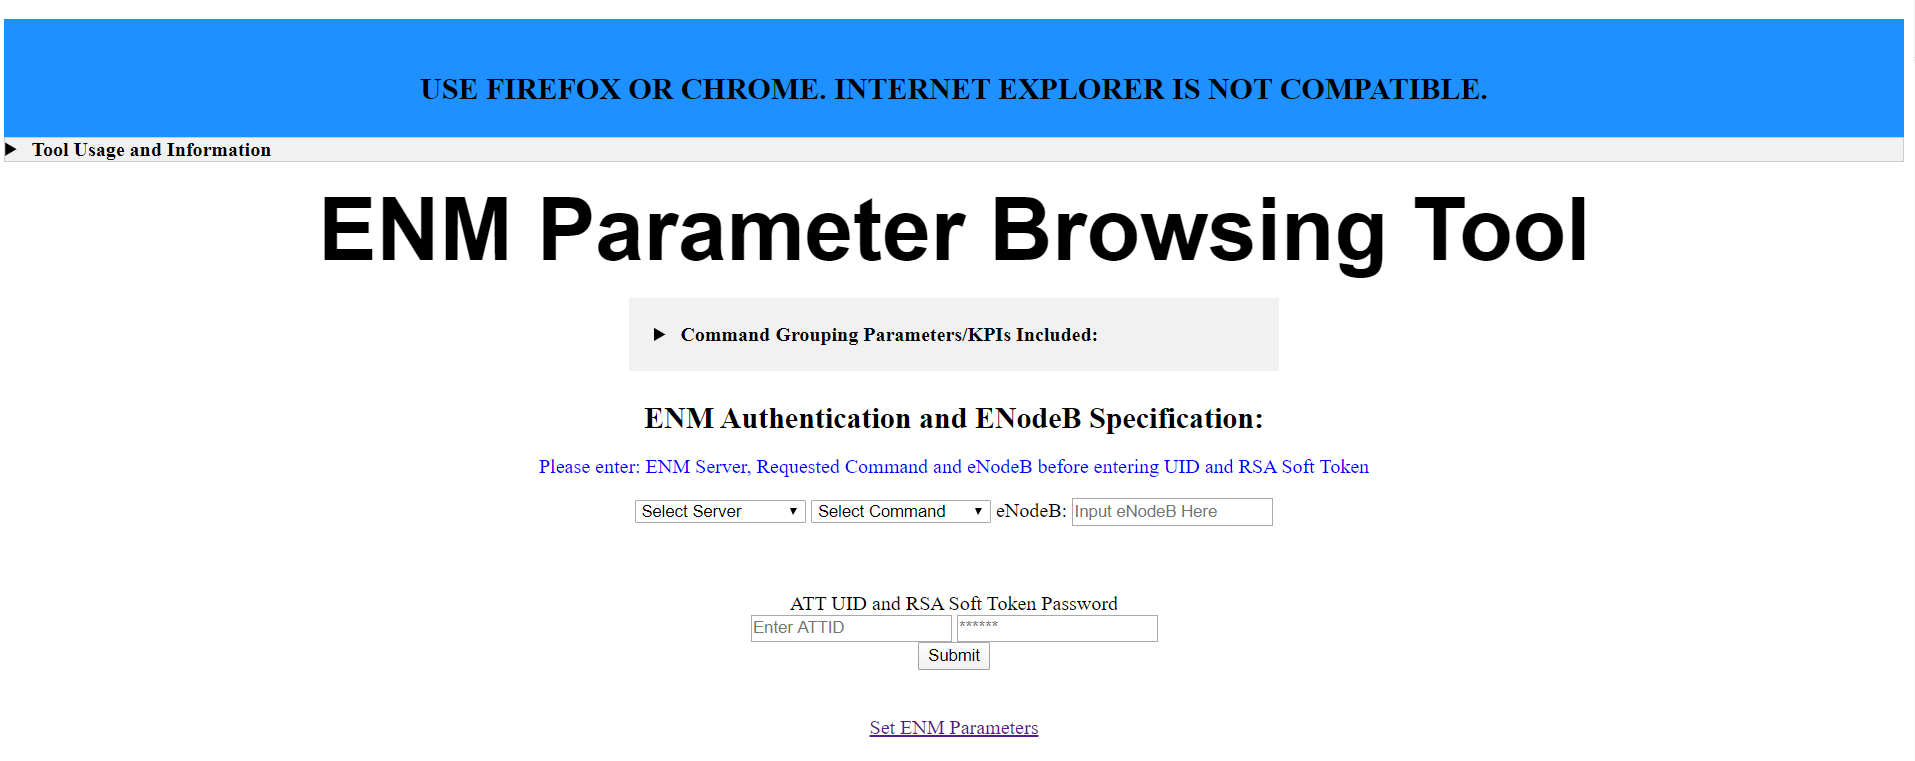


<div style="page-break-after: always;"></div>

## Scripts Used / Architecture Overview

As of March 2020, there are two versions of the script. The first version is used for test purposes / adding new command functionality testing. The second version is the live version. The second version has access to the ENM Writing Page.

*Note on Bash Scripts within the Tool:*

Bash script will be used as the landing webpages for this tool. Each of these bash scripts will utilize a designated python source file to call the a specific python script that produces the html. This is done as a work around. The python source file used within the bash script has specific modules downloaded to it that are needed to perform the functionalities within the tool's algorithms. On this apache server, I did not have the credentials to download new modules.


**Version 1 Scripts:**

- ENMScript.py/sh (Landing Page)
- ENMMOBATCHFunctions_test.py (Communication with ENM Server, processing and printing of command results)
- ENMScript_styles.py (CSS and HTML Element Definitions)
- ENMWrite_js.py (Javascript)

**Version 2 Scripts:**

- ENMScript_v2.py/sh (Landing Page for Parameter Viewing Commands)
- ENMMOBATCHFunctions.py (Communication with ENM Server, processing and printing of command results)
- ENMScript_styles.py (CSS and HTML Element definitions)
- ENMWrite.py/sh (Landing Page for Parameter Setting Commands)
- ENMWrite_js.py (Javascript)

**Existing CLI Command Script:** *See MOBATCH vs. CLI Commands*
- ENMCLIFunctions.py

*Within this document, we will use the Version 2 scripts as the default architecture.*


<div style="page-break-after: always;"></div>

## MOBATCH vs. CLI Commands

As of March 2020, the tool uses MOBATCH commands to communicate to the ENM Server. The main benefit of MOBATCH is that a command may run through completion directly from the ENM Server's command line. Meanwhile, CLI commands are not recognized from the ENM Server's command line. 

**MOBATCH:**

- General Syntax :

In [ ]:
mobatch -t 0 -p 20 '"+str(nodeId)+"' 'AMOS COMMAND HERE' logs; cat logs/"+str(nodeId)+".log\n

    When running this command externally on the specified server, the AMOS command will run directly from the ENM command 
    line, and its results will be stored in the specified file location. The name of the results file will be 
    eNodeB_Name.log. The last command in our mobatch statement is reading the contents of this file.

- Example within ENM Server:

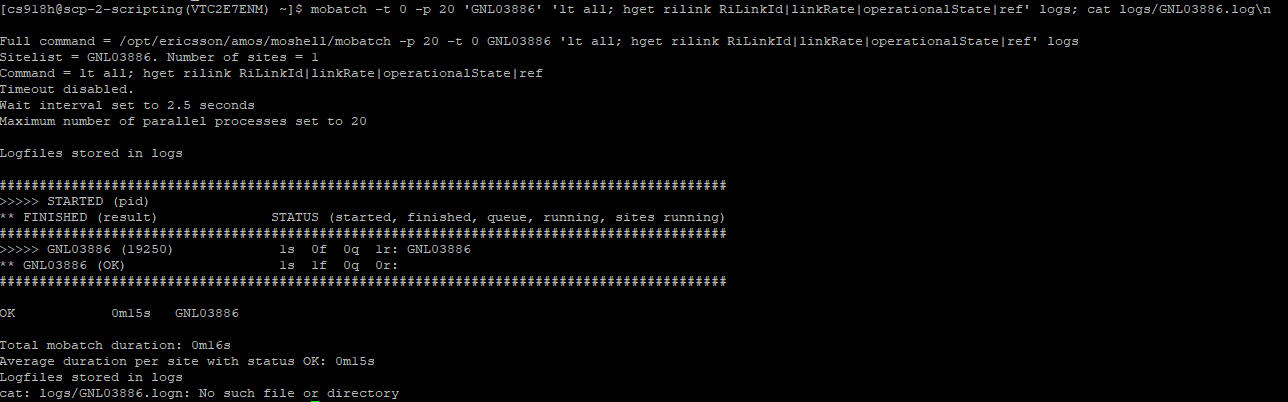

- Calling MOBATCH command from with *ENMMOBATCHFunctions.py* :

Below is the syntax that is used to run the ENM command on the ENM Server and scrape the resulting data.. 

In [ ]:
#Connect to ENM Server
client.connect(hostname=host, username=username, password=pw, port=port)
channel = client.invoke_shell()
stdin = channel.makefile('wb+')
stderr = channel.makefile_stderr('rb')
cmd = "mobatch -t 0 -p 20 '"+str(nodeId)+"' 'AMOS COMMAND HERE' logs; cat logs/"+str(nodeId)+".log\n"

#Retrieve Data
request = (cmd)
stdin.write(request)
stdin.write('exit\n')
data = stdin.read()


**CLI Commands:**
- General Syntax:

A module named ENMScripting is used to run ENM CLI commands within the ENM server. Below is the content of the Python file (commandRunner.py) that imports this module and runs a specified CLI command .. 

In [ ]:
#!/usr/bin/python
import sys
import enmscripting

cmd = ' '.join(sys.argv[1:])

session = enmscripting.open()
terminal = session.terminal()
response = terminal.execute(cmd)
for line in response.get_output():
    print(line)
print('Command Success: ' + str(response.is_command_result_available()))
enmscripting.close(session)

- Example Within ENM Server:

To execute the CLI command, run the following from the ENM Server command line .. 

In [ ]:
python commandRunner.py PLMN GNL03886

**Note:** PLMN is an alias that was created to run the desired commands. In order to have fully functional CLI commands within the tool, the alias needs to be created within all ENM servers. See External Resources for more informaton on creating aliases.


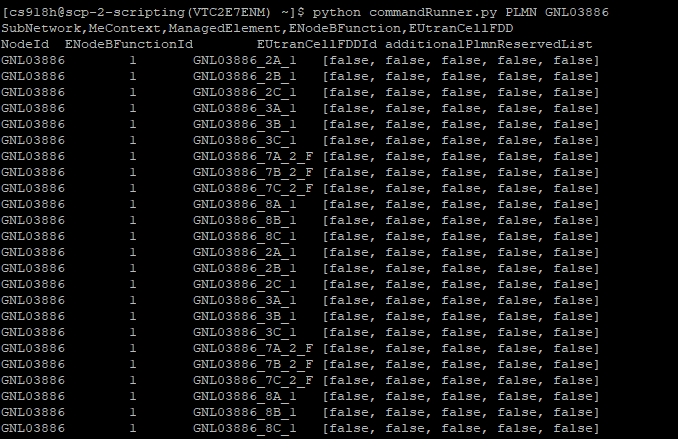

- Calling CLI command from with ENMCLIFunctions.py :
Below is the syntax that is used to run the ENM command on the ENM Server and scrape the resulting data..

In [ ]:
#Connect to ENM Server
client.connect(hostname=host, username=username, password=pw, port=port)
channel = client.invoke_shell()
stdin = channel.makefile('wb+')
stderr = channel.makefile_stderr('rb')
schmod = 'python commandRunner.py'

#Execute ENM Command and Retrieve Data
cmd = schmod + ' ' + str(commandId)+' '+str(nodeId)+"\n"
request = (cmd)
stdin.write(request)
stdin.write('exit\n')
data = stdin.read()

<div style="page-break-after: always;"></div>

## Adding New ENM Command to Tool


*Within ENMScript.py*

**Step 1)** Add command to the drop down menu in. 

In [ ]:
commandListOptions = ['5GNR/NBIoT Status',..., 'New Command']

**Step 2)** If the command option includes a space, CGI will only retrieve the first word of the dropdown option. Include the following to avoid the drop down option being cropped..

In [ ]:
if commandId == "New":
         commandId == "New ID"

*Within ENMMOBATCH_test.py*

**Step 3)** Insert the MOBATCH Command.

In [ ]:
if "Command Name" in commandId:
    cmd = "mobatch -t 0 -p 20 '"+str(nodeId)+"' 'lt all; NEW AMOS COMMAND HERE' logs; cat logs/"+str(nodeId)+".log\n"

**Step 4)** Insert the following code to call a new function in order to parse/manipulate the command's return data.

In [ ]:
if "Command Name" in commandId:
    list_data = [row.split() for row in parse(data).split('\n')]
    executeNEWCOMMAND(list_data, nodeId, ActualServ)

**Step 5)** Create the new function executeNEWCOMMAND(list_data, nodeId, ActualServ) to parse and print the data.

Once Steps 1 - 5 are completed and working correctly, move on to steps 6 - 8:

*Within ENMScript_v2.py*

**Step 6)** Copy the code from Step 1 and Step 2 into ENMScript_v2.py.

**Step 7)** Copy the code from Step 3 and Step 4 into ENMScript_v2.py.

*Within ENMScript_styles.py*

**Step 8)** Create a summary for the new command within groupParameters().

In [ ]:
def groupParameters():
        print "<div class = 'paramInfo'>"
        print "<details class = 'details' id = 'details'>"
        print "<summary> <strong> Command Grouping Parameters/KPIs Included: </strong></summary>"
        print "<p> <b>- Alarm/Radio Stats:</b> Alarm History, Radio Uptime History</p>"
        print "<p> <b>- Antenna/RET Stats:</b> Antenna Near Unit Stats, Tilt, RET Stats</p>"
        print "<p> <b>- CPRI Link Stats:</b> CPRI Link Information and Link Rate</p>"
        print "<p> <b>- KPI Summary :</b> Accessibility, Retainability, Throuput, SINR, VoLTE UL Quality (Average over the last 4 ROPs) </p>"
        print "<p> <b>- Sector Stats:</b> Sector Equipment Stats- Available HW  Output Power and Status; Sector Carrier Stats- Max TX Power, No of RX Antennas, No of TX Antennas</p>"
        print "<p> <b>- Sleep State :</b> Sleep State, Sleep Mode, Operational State, Administrative State, Locked State, Cell Barred, is DL Only, Primary PLMN Reserved (Real Time)"
        print "<p> <b>- VoLTE Stats :</b> ATT Formula VoLTE ACC Performance, ATT Formula VoLTE RET Performance, VoLTE  UE UL Quality (Last 4 ROPs)</p>"
        print "<p> <b>- NEW COMMAND NAME :</b> DESCRIPTION HERE</p>"
        print "</details></div>"

<div style="page-break-after: always;"></div>

## Command Manipulation Specifics

The general strucure of the commands execute functions is outlined below:

- Parsing data and inserting it into a list.  The following lines are used to standardize the results data before sending it to the unique execute command.


In [ ]:
def parse(data):
        xdata = data.split('\r\n')
        parsed = [row.replace('\t', '    ') for row in xdata]
        return '\n'.join(parsed)

list_data = [row.split() for row in parse(data).split('\n')]

This code was adopted from EBRAHIM JAKOET <ej4175@att.com> : http://ej.web.att.com:8080/3P_Blog/CLIweb/CLIcon.html

- External try/except statement to catch all errors. This catchall statement is attributed to errors retrieving data from AMOS (ex. lt all not executing). I t is important to catch all errors within the try statement, so the this try/except statement does not catch errors that could be resolved.

In [ ]:
def executeName(list_data, nodeId, ActualServ):
    try:
        #Manipulate and print Data
    except:
        print """<script>
        alert("Unable to gather data for the specified command. Please wait until your RSA Token passcode enters a new cycle, confirm that the eNodeB you entered matches the specified server, and try again.");
        </script>"""

- Error Handling for the case that a user does not have access to login to an eNodeB via AMOS.

*Error in AMOS*
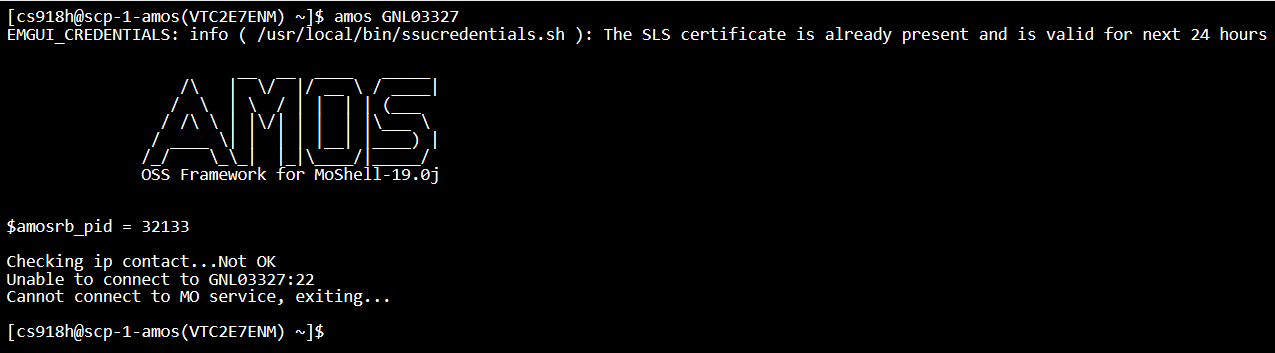

*Error Handling*

In [ ]:
killStatement = 0
    for x in list_data:
            if len(x) > 0:
                    if x == ['Cannot', 'connect', 'to', 'MO', 'service,', 'exiting...']:
                            killStatement = 1
                            break
#Manipulate Data

if killStatement == 1:
        print "User is unable to connect to MO. Access may be temporarily unavailable. To check access rights, try logging into the MO via AMOS."
else:
        #Turn data into dataframe and print to page

- Printing data. All functions use printResult(df, nodeId, ActualServ, param) to print the dataframe to the page.

In [ ]:
def printResult(df, nodeId, ActualServ, param):
        if df.empty == True:
                print "The data could not be pulled in a timely matter.. please re enter a new RSA Token passcode and rerun the command. If this issue persists, please contact the tool owners."
        else:

                print "<br><br>"
                html_str = df.to_html(header = True, index = False)
                print "<div class = 'titles' > </div><b>"+param+"</b><br>"
                print "<div class = 'tablesUser' id = 'table' style = 'width: 100%'>"
                print html_str.encode(encoding='UTF-8',errors='strict')
                print "</div><br>"

- Inserting the data into a pandas dataframe. Refer to http://ej.web.att.com:8080/3P_Blog/CLIweb/CLIcon.html .

*The remaining contents of the execute functions are unique to the specified data and desired output. Below are the existing execute functions with notes on how the data is being manipulated*
<br><br><br>

<div style="page-break-after: always;"></div>

**executeSector -- Sector Stats Command**


In [ ]:
try:
        equip = []
        carrier = []
        killStatement = 0
        for x in list_data:
                if len(x) > 0:
                        if x == ['Cannot', 'connect', 'to', 'MO', 'service,', 'exiting...']:
                                killStatement = 1
                                break

                        if "SectorEquipmentFunction" in str(x[0]):
                                xprime = x[0:6]
                                xalter = str(x[6:]).replace("',", '')
                                xalter = alarmClarifier(xalter)
                                xalter = list(xalter.split(','))
                                equip.append(xprime+xalter)
                        if "SectorCarrier" in str(x[0]):
                                xprime = x[0:6]
                                xalter = str(x[6:]).replace("',", '')
                                xalter = alarmClarifier(xalter)
                                xalter = list(xalter.split(','))
                                carrier.append(xprime+xalter)

        if killStatement == 1:
                print "User is unable to connect to MO. Access may be temporarily unavailable. To check access rights, try logging into the MO via AMOS."
        else:

                EHeader = ['MO', 'Dummy1', 'Administrative State', 'Available HW Output Power', 'Dummy2', 'Operational State', 'Reserved By']
                CHeader = ['MO', 'Configured Max TX Power', 'No Of RX Antennas', 'No Of TX Antennas', 'Dummy1', 'Operational State', 'Reserved By']
                print "<div class = 'titles' id ='title' > ENM Results (eNodeB : "+str(nodeId)+"&emsp; Server: "+str(ActualServ)+")</div><br>"
                print "<div class = 'titles' id ='title' > Command Details: KPI Tool 40 - Sector Equipment and Carrier Section - hget sectorequipm State|power|reservedby; hget sectorcarrier operationalState|nooftx|noofrx|configuredmaxtxpower|reservedby </div><br>"

                df = pd.DataFrame(equip)
                df.columns = EHeader
                df.drop(['Dummy1'], axis = 1, inplace = True)
                df.drop(['Dummy2'], axis = 1, inplace = True)
                printResult(df, nodeId, ActualServ, 'Sector Equipment Stats')

                df = pd.DataFrame(carrier)
                df.columns = CHeader
                df.drop(['Dummy1'], axis = 1, inplace = True)
                printResult(df, nodeId, ActualServ, 'Sector Carrier Stats')
except:
        print """<script>
        alert("Unable to gather data for the specified command. Please wait until your RSA Token passcode enters a new cycle, confirm that the eNodeB you entered matches the specified server, and try again.");
        </script>"""


Two data tables are being gathered here:
- eqip [] holds the data from  hget sectorequipm State|power|reservedby

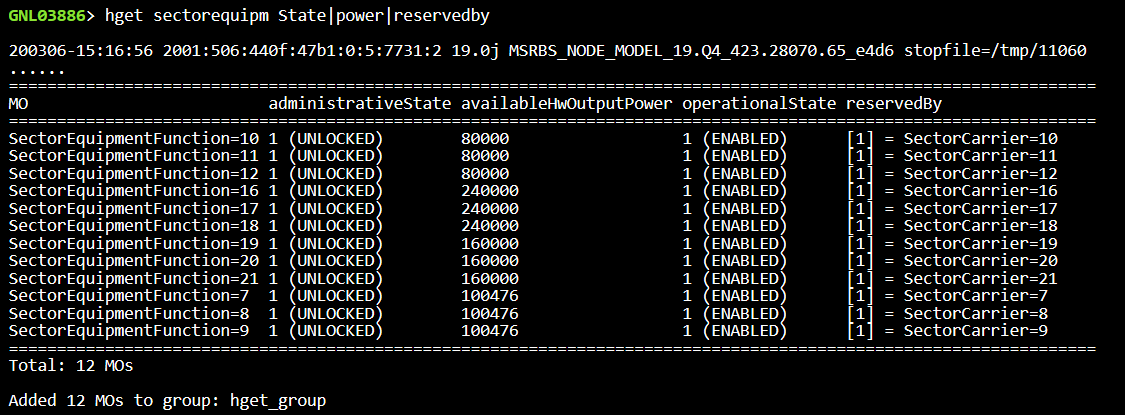

There are 2 Dummy Columns in the resulting data set (the columns of all 1s). Drop these columns before printing the table to the page.
<br>
- carrier[] holds the data from  hget sectorcarrier operationalState|nooftx|noofrx|configuredmaxtxpower|reservedby   

 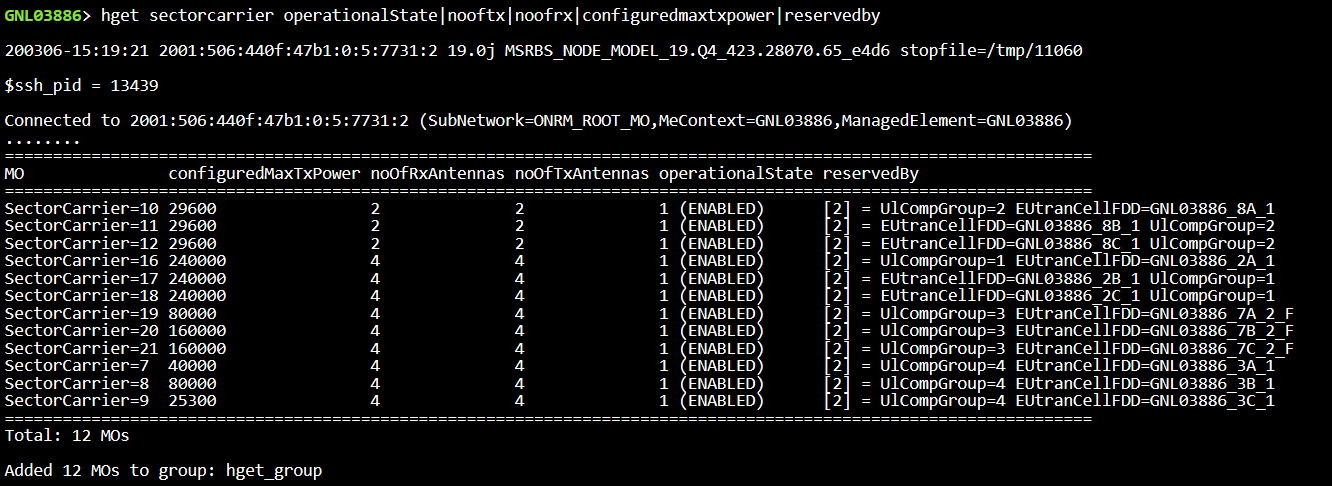
 There is 1 Dummy Column in the resulting data set (the column of all 1s). Drop this column before printing the table to the page.

<div style="page-break-after: always;"></div>

**executeAntenna -- Antenna/RET Stats Command**

In [ ]:
def executeAntenna(list_data, nodeId, ActualServ):
        try:
                killStatement = 0
                for x in list_data:
                        if x == ['Cannot', 'connect', 'to', 'MO', 'service,', 'exiting...']:
                                killStatement = 1
                                break
                if killStatement == 1:
                        print "User is unable to connect to MO. Access may be temporarily unavailable. To check access rights, try logging into the MO via AMOS."
                else:
                        ant = [x for x in list_data if len(x) == 10 or len(x) == 9]
                        Aheader = ['MO', 'Dummy1', 'Administrative State', 'iuant Device Type', 'on Unit Unique ID', 'Dummy2', 'Operational State', 'RF Port Ref', 'Unique ID']
                        merge = []
                        for x in ant:
                                if len(x)>0:
                                        if "AntennaUnitGroup" in str(x[0]):
                                                xprime = x[0:3]
                                                xend = x[5:]
                                                xalter = str(x[3:5]).replace("',", '')
                                                xalter = alarmClarifier(xalter)
                                                xalter = list(xalter.replace(' ', '-').split(','))
                                                merge.append(xprime+xalter+xend)

                        print "<div class = 'titles' id ='title' > ENM Results (eNodeB : "+str(nodeId)+"&emsp; Server: "+str(ActualServ)+")</div><br>"
                        print "<div class = 'titles' id ='title' > Command Details: KPI Tool 40 - Antenna and RET Section - lhget AntennaNearUnit iuantdevicetype|uniqueid|state|rfportref; lhget RetSubunit electrical|operationalState|iuantBaseStationId|userlabel </div><br>"
                        df = pd.DataFrame(merge)
                        df.columns = Aheader
                        df.drop(['Dummy1'], axis = 1, inplace = True)
                        df.drop(['Dummy2'], axis = 1, inplace = True)
                        printResult(df, nodeId, ActualServ, 'Antenna Near Unit')

                        ant = [x for x in list_data if len(x) == 3]
                        antOK = []
                        for x in ant:
                                if "AntennaUnitGroup" in str(x[0]):
                                        antOK.append(x)

                        Aheader = ['MO', 'Dummy1', 'Operational State']
                        df = pd.DataFrame(antOK)
                        df.columns = Aheader
                        df.drop(['Dummy1'], axis = 1, inplace = True)
                        printResult(df, nodeId, ActualServ, 'Antenna Near Unit - 6 MOs Added')

                        ret = [x for x in list_data if len(x) == 6]
                        Rheader = ['MO', 'Electrical Tilt', 'iuant Base Station ID', 'Dummy1', 'Operational State', 'User Label']
                        retOK = []
                        for x in ret:
                                if "AntennaUnitGroup" in str(x[0]):
                                        retOK.append(x)

                        df = pd.DataFrame(retOK)
                        df.columns = Rheader
                        df.drop(['Dummy1'], axis = 1, inplace = True)
                        printResult(df, nodeId, ActualServ, 'RET Subunit Stats')
        except:
                print("""<script>
                alert("Unable to gather data for the specified command. Please wait until your RSA Token passcode enters a new cycle, confirm that the eNodeB you entered matches the specified server, and try again. See Tool Usage and Information for more details.");
                </script>""")

Three data tables are being gathered here:
- ant [] holds the 2 data tables from  lhget AntennaNearUnit iuantdevicetype|uniqueid|state|rfportref
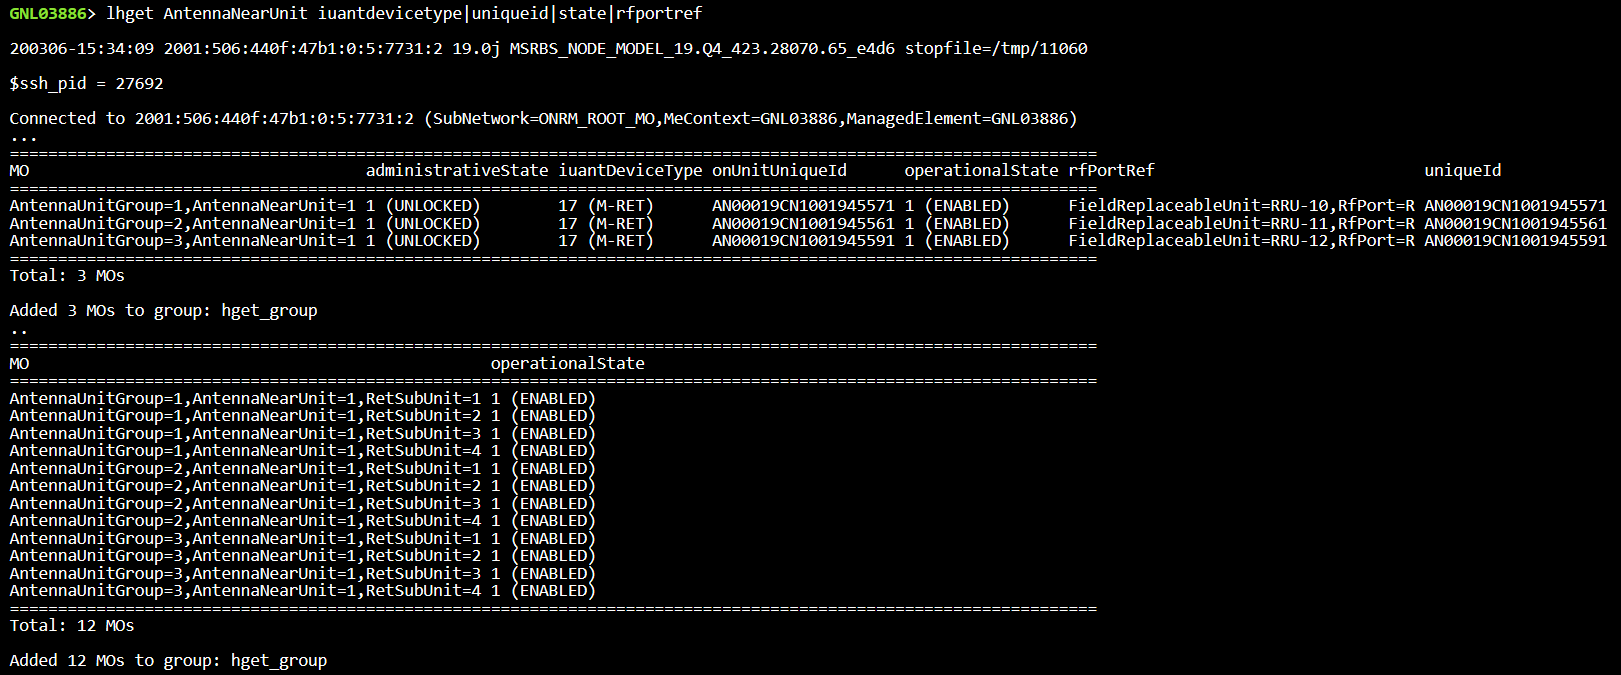

The first data table has 9/10 columns (depending on whether or not a uniquID is available). If a row in list data has 9/10 columns, it is captures. From this captured data, only the rows that have "AntennaUnitGroup" in the first column value are used.. this filters out noise rows that are also of length 9/10. 

Additional manipulation is ncessary to account for the spaces within the iuantDeviceType values. 


In [ ]:
xprime = x[0:3]
xend = x[5:]
xalter = str(x[3:5]).replace("',", '')
xalter = alarmClarifier(xalter)
xalter = list(xalter.replace(' ', '-').split(','))
merge.append(xprime+xalter+xend)

The first data table has 3 columns (depending on whether or not a uniquID is available). If a row in list data has 3 columns, it is captures. From this captured data, only the rows that have "AntennaUnitGroup" in the first column value are used.. this filters out noise rows that are also of length 3.


- ret[] holds the data from  lhget RetSubunit electrical|operationalState|iuantBaseStationId|userlabel
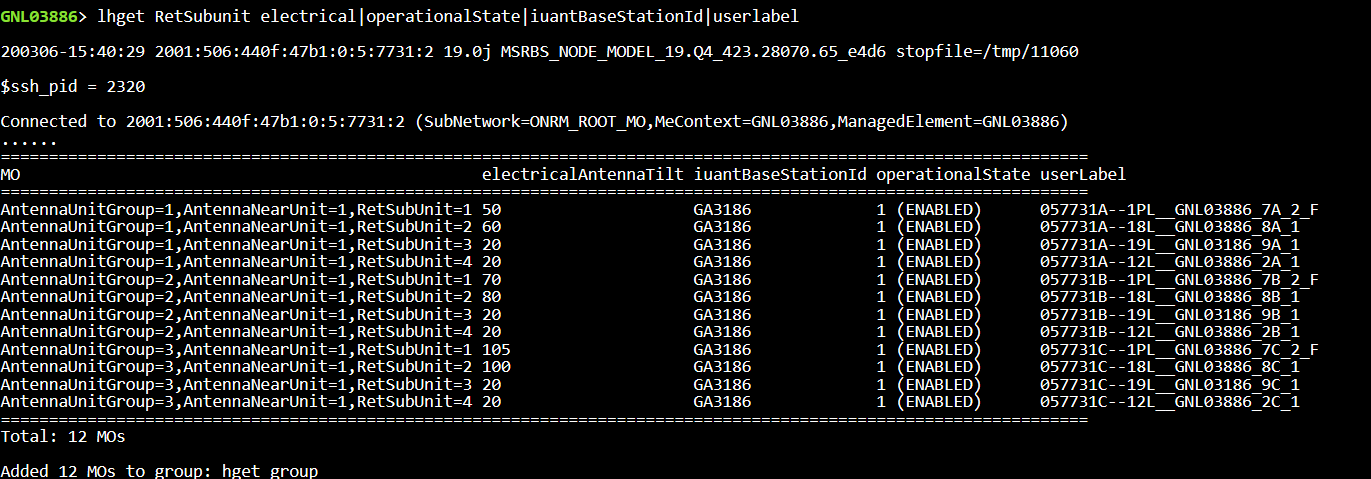


The first data table has 6 columns. If a row in list data has 6 columns, it is captures. From this captured data, only the rows that have "AntennaUnitGroup" in the first column value are used.. this filters out noise rows that are also of length 6. 


<div style="page-break-after: always;"></div>

**executeAlarm -- Alarm Stats Command**

In [ ]:
try:
        stat = [x for x in list_data if len(x) > 0 and x[0] == '>>>' ]
        alarms = []
        alarmRs = 0
        for x in list_data:
                if len(x) > 0 and 'Date' in str(x[0]):
                        alarmRs += 1
                if alarmRs == 1 :
                        if '-' in str(x[0]):
                                #Iniital 3 values split correctly
                                xprime = str(x[0:3]).replace("',", '')
                                xprime = alarmClarifier(xprime)
                                xprime = xprime.replace(' ', ',')
                                #Manipulate the remainder of the string to not split on spaces
                                sp = str(x[3:]).replace("',", '')
                                spRaw = alarmClarifier(sp)
                                try:
                                        sp = spRaw.split('ENodeBFunction=')
                                        sp2 = 'ENodeBFunction='+ str(sp[1])
                                except:
                                        sp = spRaw.split('FieldReplaceableUnit=')
                                        sp2 = 'FieldReplaceableUnit='+str(sp[1]).replace(',', ' ')
                                y = xprime + "," +sp[0]+","+sp2[0]+","+sp2
                                alarms.append(list(y.split(',')))
                if len(x) > 0 and '>>>' in str(x[0]):
                        alarmRs = 0

        print "<div class = 'titles' id ='title' > ENM Results (eNodeB : "+str(nodeId)+"&emsp; Server: "+str(ActualServ)+")</div><br>"
        print "<div class = 'titles' id ='title' > Command Details: KPI Tool 40 - Alarms Section - *alt*</div><br>"

        if len(alarms) >0:
                Adf = pd.DataFrame(alarms)
                Adf.columns = ['Date', 'Time', 'Severity', 'Specific Problem', 'Dummy', 'MO (Cause/Additional Info)']
                Adf.drop(['Dummy'], axis = 1, inplace = True)
                printResult(Adf, nodeId, ActualServ, "Alarms")

        stat = str(stat).replace("',", '')
        stat = alarmClarifier(stat)
        print stat

except:
        print """<script>
        alert("Unable to gather data for the specified command. Please wait until your RSA Token passcode enters a new cycle, confirm that the eNodeB you entered matches the specified server, and try again.");
        </script>"""


One data tables is being gathered here:
- alarms [] holds the data from  alt

- stat captured the last line from alt in which the total alarms is outputted. 

In [ ]:
stat = [x for x in list_data if len(x) > 0 and x[0] == '>>>' ]


*No Alarms*
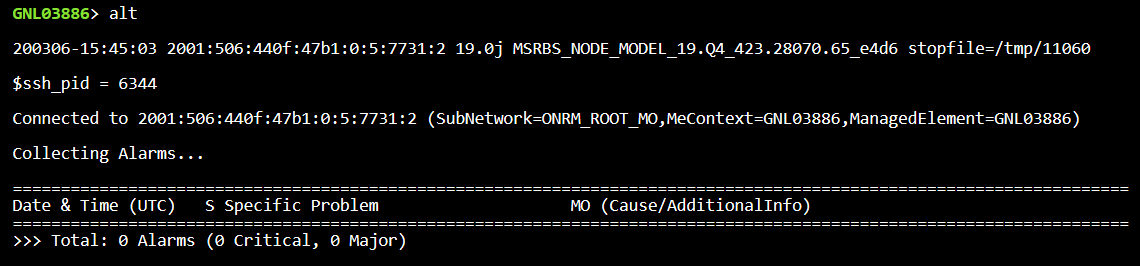


*Three Alarms*

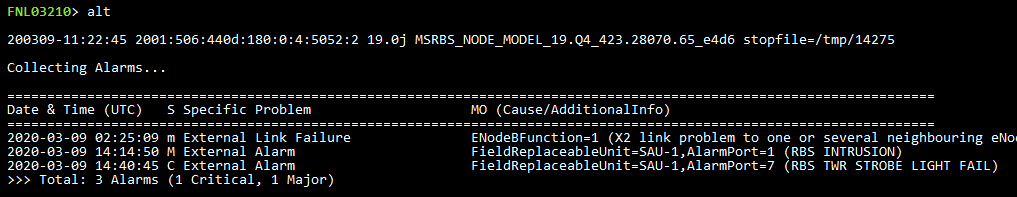

For all alt command outputs, the first component in the title of the results output table in AMOS is *Date & Time*. In order to capture the return statement of an eNodeB's alarms, alarmRS is set to 1 when the first index of list_data contains *Date*. Once alarmRs has been set to one, all rows with *-* in the first index (i.e. rows with an alarm date in the first index) are identified as being an alarm and captured. 

The data manipulation keeps the first three columns as is (separated by a comma). In order to capture the specific problem, indexes 3 - instance of ENodeBFunction or FieldReplaceableUnit are captured, and commas are replaced by a space. (This code is functional for alarm MOs ENodeBFunction and FieldReplaceableUnit only). The elements after the instance of ENodeBFunction or FieldReplaceableUnit are combined, replacing a comma with a space. All elements are then combined to form a new row, y, where each column is separated by a comma. This new row is appended to alarms.

For eNodeB's with no alarms, alarms [] will not be populated, and only the stat value will be printed to the webpage.

In [ ]:
if len(alarms) >0:
        Adf = pd.DataFrame(alarms)
        Adf.columns = ['Date', 'Time', 'Severity', 'Specific Problem', 'ENodeBFunction (MO)', 'Cause/Additional Info']
        printResult(Adf, nodeId, ActualServ, "Alarms")

stat = str(stat).replace("',", '')
stat = alarmClarifier(stat)
print stat

<div style="page-break-after: always;"></div>

**executeRU-- Radio Stats Command**

In [ ]:
def executeRU(list_data, nodeId, ActualServ):
        try:
                ru =[]
                for x in list_data:
                        if len(x) > 0 and 'BXP_' in str(x[0]):
                                x = str(x).replace("',", '')
                                x = alarmClarifier(x)
                                x = x.replace("load average: ", '')
                                ru.append(list(x.split(',')))
                RUdf = pd.DataFrame(ru)
                if len(RUdf.columns) == 1:
                        RUdf.columns = ['BXP Details']
                if len(RUdf.columns) == 5:
                        RUdf.columns = ['BXP Details', 'Number of Users', 'Load Average', 'Load Average', 'Load Average']
                if len(RUdf.columns) == 6:
                        RUdf.columns = ['BXP Details', 'Time', 'Number of Users', 'Load Average', 'Load Average', 'Load Average']

                print "<div class = 'titles' id ='title' > ENM Results (eNodeB : "+str(nodeId)+"&emsp; Server: "+str(ActualServ)+")</div><br>"
                print "<div class = 'titles' id ='title' > Command Details: KPI Tool 40 - Radio Uptime Section - <i>lh ru uptime</i> </div><br>"
                printResult(RUdf, nodeId, ActualServ, "Radio Uptime Stats")

        except:
                print """<script>
                alert("Unable to gather data for the specified command. Please wait until your RSA Token passcode enters a new cycle, confirm that the eNodeB you entered matches the specified server, and try again.");
                </script>"""


One data tables is being gathered here:
- ru [] holds the data from  lh ru uptime

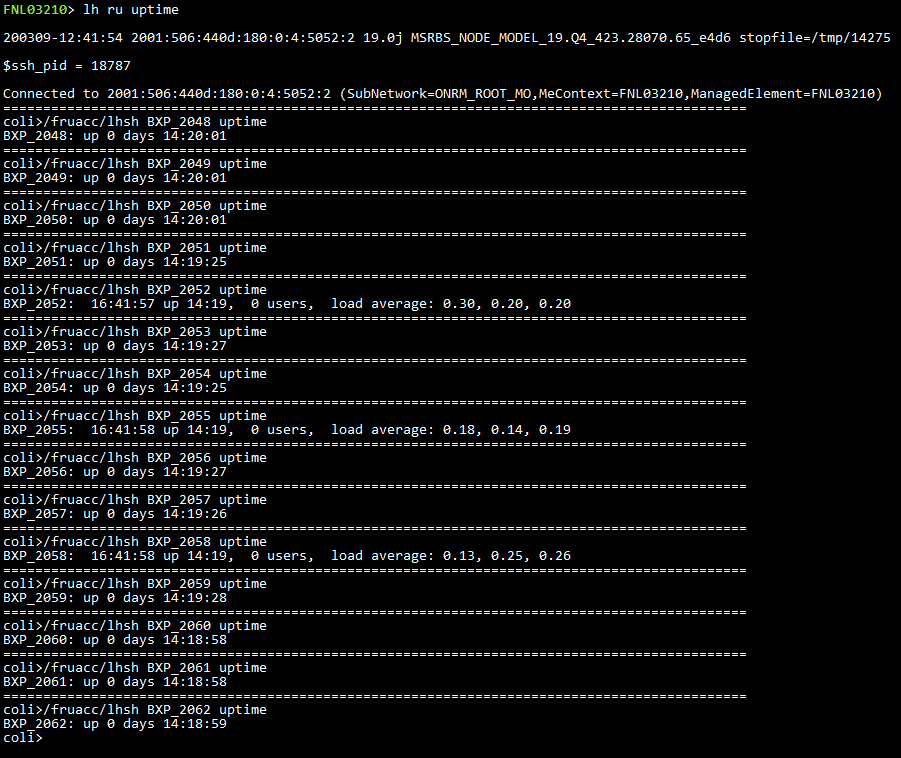

Only the rows that have "BXP_" in the first column value are used. Additional manipulation is necessary to account for the spaces/commas in the resulting output lines. Load Average: is also dropped from the cell value and included as a header name. 


Results tables format with displaying the time has varied (some reults include a comma separation between the BXP Details and the time, others do not). The following catches the results table formats *that have been observed to date*. This is not a catch all!

In [ ]:
if len(RUdf.columns) == 1:
        RUdf.columns = ['BXP Details']
if len(RUdf.columns) == 5:
        RUdf.columns = ['BXP Details', 'Number of Users', 'Load Average', 'Load Average', 'Load Average']
if len(RUdf.columns) == 6:
        RUdf.columns = ['BXP Details', 'Time', 'Number of Users', 'Load Average', 'Load Average', 'Load Average']

Some output does not have any information other than the BXP details. The code below catches these cases..

In [ ]:
try:
        RUdf.columns = ['BXP Details', 'Time', 'Number of Users', 'Load Average', 'Load Average', 'Load Average']
except:
        RUdf.columns = ['BXP Details']

<div style="page-break-after: always;"></div>

**executeVoLTE-- VoLTE Stats Command**

In [ ]:
def executeVoLTE(list_data, nodeId, ActualServ):
    try:
            killStatement = 0
            for x in list_data:
                    if x == ['Cannot', 'connect', 'to', 'MO', 'service,', 'exiting...']:
                            killStatement = 1
                            break
            if killStatement == 1:
                    print "User is unable to connect to MO. Access may be temporarily unavailable. To check access rights, try logging into the MO via AMOS."
            else:
                    """Context: All VoLTE Params 6 vals ==> Separate based off of 'Counter' """
                    volte = [x for x in list_data if len(x) == 6 ]
                    volte = volte[2:]
                    header = volte.pop(0) 
                    df = pd.DataFrame(volte)
                    df.transpose()
                    df.columns = header
                    df.columns = ['eNodeB Cell' if x=='Object' else x for x in df.columns]
                
                    acc = df[df.Counter == 'ATTv_Acc_pct']
                    ret = df[df.Counter == 'ATTv_Ret_pct']
                    qual = df[df.Counter == 'VoIpUeQualityRate']

                    acc.drop(['Counter'], axis = 1, inplace = True)
                    ret.drop(['Counter'], axis = 1, inplace = True)
                    qual.drop(['Counter'], axis = 1, inplace = True)

                    print "<div class = 'titles' id ='title' > ENM Results (eNodeB : "+str(nodeId)+"&emsp; Server: "+str(ActualServ)+")</div><br>"
                    print "<div class = 'titles' id ='title' > Command Details: KPI Tool - 15, 16, & 17</div><br>"

                    printResult(acc, nodeId, ActualServ, 'ATT Formula - VoLTE ACC Performance (ATTv_Acc_pct)')
                    printResult(ret, nodeId, ActualServ, 'ATT Formula VoLTE RET Performance (ATTv_Ret_pct)')
                    printResult(qual, nodeId, ActualServ, 'VoLTE  UE UL Quality – Percentage of UE that are satisfied with their VoIP quality (VoIpUeQualityRate)')
    except:
            print """<script>
            alert("Unable to gather data for the specified command. Please wait until your RSA Token passcode enters a new cycle, confirm that the eNodeB you entered matches the specified server, and try again. See Tool Usage and Information for more details.");
            </script>"""

Three data tables are populated here. The output tables for ATTv_Acc_pct, ATTv_Ret_pct, and VoIpUeQualityRate all contain 6 columns. volte [] captures all of the data, the first 2 rows returned are not necessarry and are dropped, and then volte is parsed by specified counter. Once the counter has been used to subset volte[] into the three tables, it is dropped.

<div style="page-break-after: always;"></div>

**executeSleep-- Sleep State Command**

In [ ]:
def executeSleep(list_data, nodeId, ActualServ):
    try:
            killStatement = 0
            for x in list_data:
                    if x == ['Cannot', 'connect', 'to', 'MO', 'service,', 'exiting...']:
                            killStatement = 1
                            break
            if killStatement == 1:
                    print "User is unable to connect to MO. Access may be temporarily unavailable. To check access rights, try logging into the MO via AMOS."
            else:
                    """Context: Headers 3 columns; data 5 vals ==> Hardcoding the Headers as a result"""
                    sleep = [x for x in list_data if len(x) == 5 ]
                    sleep = sleep[5:]
                    headerSl = ['eNodeB Cell', 'dummy1', 'Sleep Mode', 'dummy2', 'Sleep State']
                    dfSl = pd.DataFrame(sleep)
                    dfSl.transpose()
                    dfSl.columns = headerSl
                    dfSl.drop(['dummy1'], axis = 1, inplace = True)
                    dfSl.drop(['dummy2'], axis = 1, inplace = True)

                    """Context: Headers 6 columns; data 9 vals ==> Hardcoding the Headers as a result"""
                    eu = [x for x in list_data if len(x) == 9 ]
                    eu = eu[3:]
                    headerEu = ['eNodeB Cell', 'dummy1', 'Administrative State', 'dummy2', 'Cell Barred', 'is DL Only', 'dummy3', 'Operational State', 'Primary PLMN Reserved']
                    dfEu = pd.DataFrame(eu)
                    dfEu.transpose()
                    dfEu.columns = headerEu
                    dfEu.drop(['dummy1'], axis = 1, inplace = True)
                    dfEu.drop(['dummy2'], axis = 1, inplace = True)
                    dfEu.drop(['dummy3'], axis = 1, inplace = True)

                    #Merge dfs and drop columns that are unwanted (going off of Peter's snapshot)
                    df = dfSl.merge(dfEu)

                    print "<div class = 'titles' id ='title' > ENM Results (eNodeB : "+str(nodeId)+"&emsp; Server: "+str(ActualServ)+")</div><br>"
                    print "<div class = 'titles' id ='title' > Command Details: hget ^EUtranCellFDD administrativeState|cellBarred|operationalState|primaryPlmnReserved|isDlOnly; hget ^CellSleepFunction SleepState|sleepMode </div><br>"

                    printResult(df, nodeId, ActualServ, 'Sleep State Results')
    except:
            print """<script>
            alert("Unable to gather data for the specified command. Please wait until your RSA Token passcode enters a new cycle, confirm that the eNodeB you entered matches the specified server, and try again. See Tool Usage and Information for more details.");
            </script>"""

The data response tables for two commands are combined to print one table to the webpage here. The sleep state command results have 5 columns. All rows with 5 columns are gathered, and unnecesary ones are dropped. Unnecessary columns are dropped. The eNodeB Function command results have 9 columns. All rows with 9 columns are gathered, and unnecesary ones are dropped. Unnecessary columns are dropped. 

The two results dataframes are merged together and printed to the page.

<div style="page-break-after: always;"></div>

**executePLMN-- PLMN State Command**

In [ ]:
def executePLMN(list_data, nodeId, ActualServ):
    try:
            killStatement = 0
            for x in list_data:
                    if x == ['Cannot', 'connect', 'to', 'MO', 'service,', 'exiting...']:
                            killStatement = 1
                            break
            if killStatement == 1:
                    print "User is unable to connect to MO. Access may be temporarily unavailable. To check access rights, try logging into the MO via AMOS."
            else:
                    """Context: Headers 9 columns; data 16 vals ==> Hardcoding the Headers as a result. PLMNS on different lines"""
                    data = [x for x in list_data if len(x) == 14]
                    header = ['eNodeB Cell', 'dummy1', 'dummy2', 'PLMN1 Reserved', 'PLMN2 Reserved', 'PLMN3 Reserved', 'PLMN4 Reserved', 'PLMN5 Reserved', 'dummy3', 'Administrative State', 'dummy4', 'Cell Barred', 'is DL Only', 'Primary PLMN Reserved']
                    df = pd.DataFrame(data)
                    df.transpose()
                    df.columns = header
                    df.drop(['dummy1'], axis = 1, inplace = True)
                    df.drop(['dummy2'], axis = 1, inplace = True)
                    df.drop(['dummy3'], axis = 1, inplace = True)
                    df.drop(['dummy4'], axis = 1, inplace = True)
                    df.drop(['Primary PLMN Reserved'], axis = 1, inplace = True)


                    """Context: Headers 4 columns; data 4 vals ==>  Merge MCC-MNC ==> Merge PLMN-PLMN"""
                    plmn = [x for x in list_data if len(x) == 4]
                    plmn = plmn[14:]
                    header = ['eNodeB Cell', 'MCC', 'MNC', 'MNC Length']
                    df2 = pd.DataFrame(plmn)
                    df2.transpose()
                    df2.columns = header

                    df2['PLMN'] = df2[['MCC', 'MNC']].apply(lambda x: ''.join(x), axis=1)
                    count = 0
                    plmnsMagnum = []
                    for index, row in df2.iterrows():
                            if count % 2 == 0:
                                    plmns = [row['PLMN']]
                            else:
                                    plmns.append(row['PLMN'])
                                    plmnsMagnum.append(plmns)
                            count += 1

                    df['PLMNs'] = plmnsMagnum
                    df = df[['eNodeB Cell', 'PLMNs', 'PLMN1 Reserved', 'PLMN2 Reserved', 'PLMN3 Reserved', 'PLMN4 Reserved', 'PLMN5 Reserved', 'Administrative State', 'Cell Barred', 'is DL Only']]
                    print "<div class = 'titles' id ='title' > ENM Results (eNodeB : "+str(nodeId)+"&emsp; Server: "+str(ActualServ)+")</div><br>"
                    print "<div class = 'titles' id ='title' > Command Details: hget ^EUtranCellFDD administrativeState|cellBarred|activePLMNList|primaryPLMNReserved|additionalPLMNReservedList|isDlOnly </i> </div><br>"
                    printResult(df, nodeId, ActualServ, 'PLMN Results')

    except:
            print """<script>
            alert("Unable to gather data for the specified command. Please wait until your RSA Token passcode enters a new cycle, confirm that the eNodeB you entered matches the specified server, and try again. See Tool Usage and Information for more details.");
            </script>"""


The following AMOS output requires multiple lines to return a single eNodeB's output.

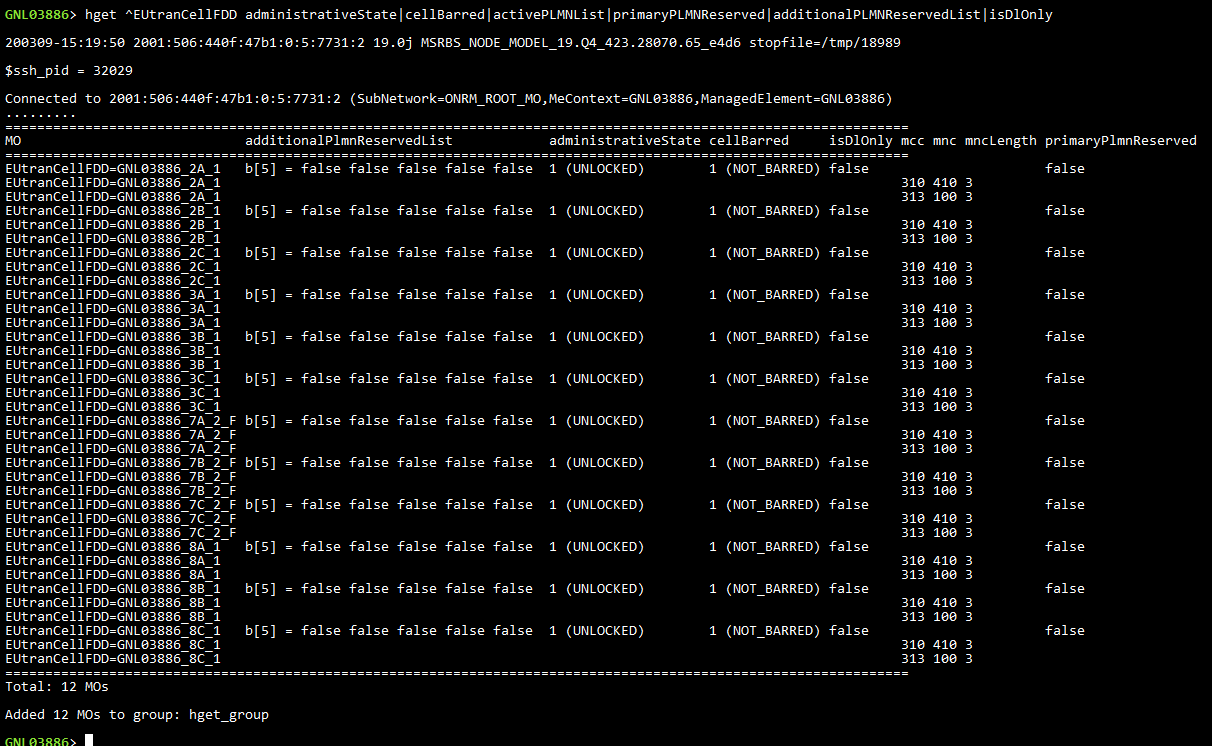

The first row maps to 9 columns; the second and third maps to 4. These rows are gathered by this unique row length, and excess data rows are dropped. For each eNodeB, their following code combines the MCC and MNC columns one access code, and saves the value as a PLMN. This PLMN is appended to plmnsMagnum [].

In [ ]:
df2['PLMN'] = df2[['MCC', 'MNC']].apply(lambda x: ''.join(x), axis=1)
count = 0
plmnsMagnum = []
for index, row in df2.iterrows():
        if count % 2 == 0:
                plmns = [row['PLMN']]
        else:
                plmns.append(row['PLMN'])
                plmnsMagnum.append(plmns)
        count += 1

df['PLMNs'] = plmnsMagnum

<div style="page-break-after: always;"></div>

**executeCPRI-- CPRI State Command**


In [ ]:
def executeCPRI(list_data, nodeId, ActualServ):
    try:
            Cheader = ['MO', 'Link Rate', 'Dummy1', 'Operational State', 'RI Link ID', 'RI Port Ref 1', 'RI Port Ref 2']
            cpri = []
            killStatement = 0
            for x in list_data:
                    if x == ['Cannot', 'connect', 'to', 'MO', 'service,', 'exiting...']:
                            killStatement = 1
                            break
                    if len(x) > 0:
                            if "RiLink" in str(x[0]):
                                    cpri.append(x)
            print "<div class = 'titles' id ='title' > ENM Results (eNodeB : "+str(nodeId)+"&emsp; Server: "+str(ActualServ)+")</div><br>"
            print "<div class = 'titles' id ='title' > Command Details: KPI Tool 40 - CPRI Link Status Section - hget rilink RiLinkId|linkRate|operationalState|ref </div><br>"
            if killStatement == 1:
                    print "User is unable to connect to MO. Access may be temporarily unavailable. To check access rights, try logging into the MO via AMOS."
            else:
                    df = pd.DataFrame(cpri)
                    df.columns = Cheader
                    df.drop(['Dummy1'], axis = 1, inplace = True)
                    printResult(df, nodeId, ActualServ, 'CPRI Link Stats')
    except:
            print """<script>
            alert("Unable to gather data for the specified command. Please wait until your RSA Token passcode enters a new cycle, confirm that the eNodeB you entered matches the specified server, and try again. See Tool Usage and Information for more details.");
            </script>"""


The results from the CPRI command are returned in a single table.

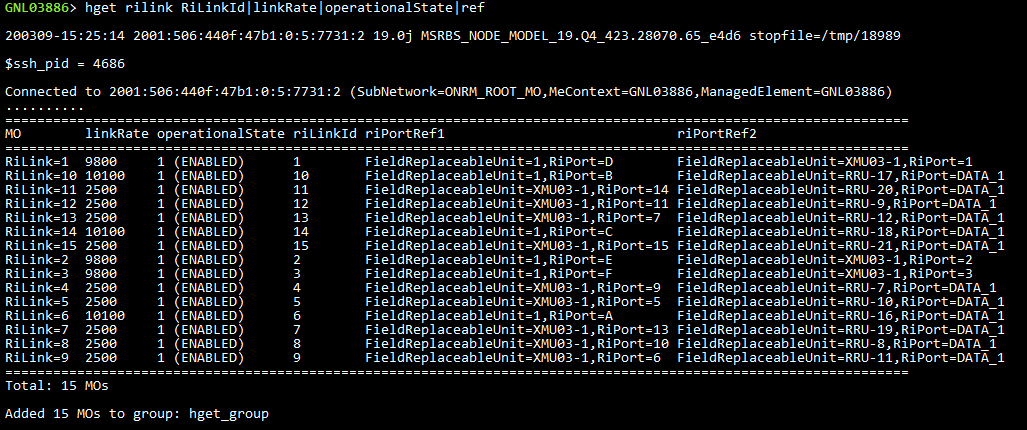

All results rows that we are interested in capturing hace RiLink within the first index. These rows are captured accordingly.

<div style="page-break-after: always;"></div>

**executeFIVE-- 5GNR/NBIoT Status Command**

In [ ]:
def executeFIVE(list_data, nodeId, ActualServ):
    try:
            five = []
            nbiot = []
            FStart1 = 0
            FStart2 = 0
            NStart = 0
            killStatement = 0

            for x in list_data:
                    if len(x) > 2:
                            if x == ['Cannot', 'connect', 'to', 'MO', 'service,', 'exiting...']:
                                    killStatement = 1
                                    break
                            if "NRCellDU" in str(x[2]):
                                    FStart1 = 1
                            if "NRCellCU" in str(x[2]):
                                    FStart2 = 1
                            if "NbIotCell" in str(x[2]):
                                    NStart = 1
                            if "PmGroup=NRCell" in str(x[0]):
                                    #Description has arbitrary spaces
                                    xalter = str(x[1:-9]).replace("',", '')
                                    xalter = alarmClarifier(xalter)
                                    xalter = list(xalter.split(','))
                                    xNew = x[0:1]+xalter+x[-9:]
                                    if len(xNew) == 11: #switching Technology NA
                                            xprime = xNew[0:8] # pmGroupVersion Spacing Issue
                                            xend = xNew[-1:]
                                            xalter = str(xNew[8:-1]).replace("',", '')
                                            xalter = alarmClarifier(xalter)
                                            xalter = list(xalter.split(','))
                                            xalter = xalter + ['N/A']
                                    if len(xNew) == 12: #switching Technology Present
                                            xprime = xNew[0:7] # pmGroupVersion Spacing Issue
                                            xend = xNew[-2:]
                                            xalter = str(xNew[7:-2]).replace("',", '')
                                            xalter = alarmClarifier(xalter)
                                            xalter = list(xalter.split(','))
                                    five.append(xprime+xalter+xend)
                            if "NbIotCell" in str(x[0]):
                                    xprime = list(str(x[0].replace('NbIotCell=','')).split(','))
                                    xprimeI = x[1:3]
                                    if len(x) == 10:
                                            xalter = str(x[3:6]).replace("',", '')
                                            xalter = xalter.replace("'", '')
                                            xalter = list(xalter.split(','))
                                            xend = x[6:]
                                    else:
                                            xalter = str(x[3:5]).replace("',", '')
                                            xalter = xalter.replace("'", '')
                                            xalter = list(xalter.split(','))
                                            xend = x[5:]
                                    nbiot.append(xprime+xprimeI+xalter+xend)
            if killStatement == 1:
                    print "User is unable to connect to MO. Access may be temporarily unavailable. To check access rights, try logging into the MO via AMOS."
            else:
                    NHeader = ['MO', 'Dummy1', 'Administrative State', 'Availability Status', 'Cell Barred', 'Cell Id', 'Dummy2', 'Operational State']
                    FHeader = ['MO', 'Description', 'Generation', 'MIM Name', 'MIM Release', 'MIM Version', 'MO Class Name', 'PM Group ID', 'PM Group Version', 'Switching Technology', 'Validity']
                    print "<div class = 'titles' id ='title' > ENM Results (eNodeB : "+str(nodeId)+"&emsp; Server: "+str(ActualServ)+")</div><br>"
                    print "<div class = 'titles' id ='title' > Command Details: KPI Tool 40 - 5G NR/NBIoT Cell Status Section - lhget NRCellDU ; hget NRCellCU ; lhget NbIotCell administrativeState|operationalState|barred|availabilityStatus|^cellId </div><br>"
                    if FStart1 == 1 and FStart2 == 1 and len(five) == 0:
                            print "<br><b>"+ str(nodeId) + " Does Not Have Any 5G NR Carriers to Report.</b></br>"
                    else:
                            df = pd.DataFrame(five)
                            df.columns = FHeader
                            printResult(df, nodeId, ActualServ, '5G NR Cell Status')

                    if NStart == 1 and len(nbiot) == 0:
                            print  "<br><b>"+ str(nodeId) + " Does Not Have Any NB IoT Carriers to Report.</b></br>"
                    else:
                            df = pd.DataFrame(nbiot)
                            df.columns = NHeader
                            df.drop(['Dummy1'], axis = 1, inplace = True)
                            df.drop(['Dummy2'], axis = 1, inplace = True)
                            printResult(df, nodeId, ActualServ, 'NB IoT Cell Status')
    except:
            print """<script>
            alert("Unable to gather data for the specified command. Please wait until your RSA Token passcode enters a new cycle, confirm that the eNodeB you entered matches the specified server, and try again.");
            </script>"""

Three results tables are combined into two tables that are printed to the webpage. The 5GNR Results Table is the concatenation of the following results:

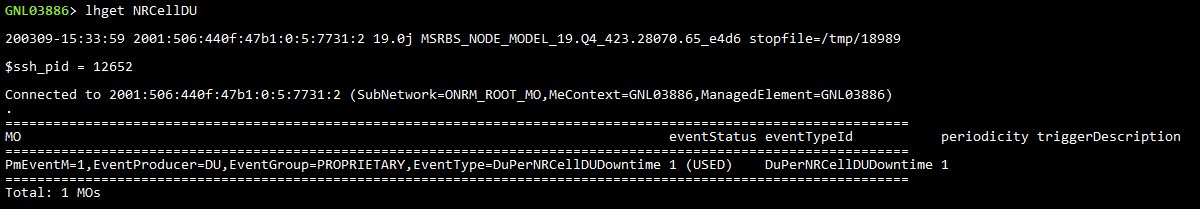

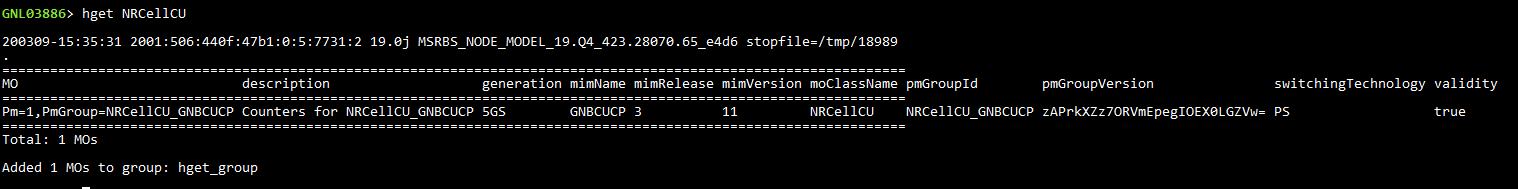

For the result tables for both lhget NRCellDU and hget NRCellCU , PmGroup=NRCell is within the second index of the results row. The data is filtered by this characteristic.

Hard indexing is used to manipulate the results data. x[1:-9] grabs the description data, and replaces commas with a space so that it my be parsed into the same column. 

If switching technology data is present. The altered results row will have length of 12; else it will have length 11. For both cases, the initial column values through pmGroupId are saved as xprime; switching technology (NA if none) and validity are saved as xend. The data corresponding to pmGroupVersion is manipulated to change all commas to spaces, so that it will be parsed into a single column.


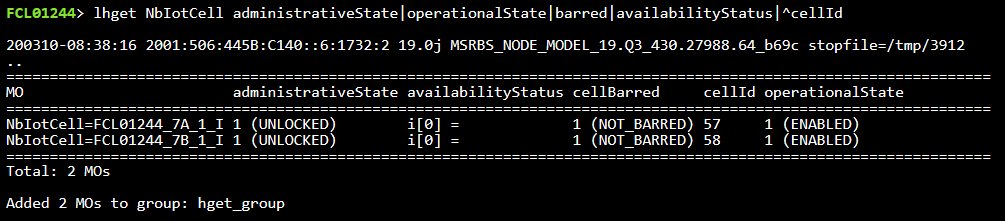

<div style="page-break-after: always;"></div>

## External Resources


### KPI Tool: 

run /home/shared/rp7608/myscript/KPI.mos

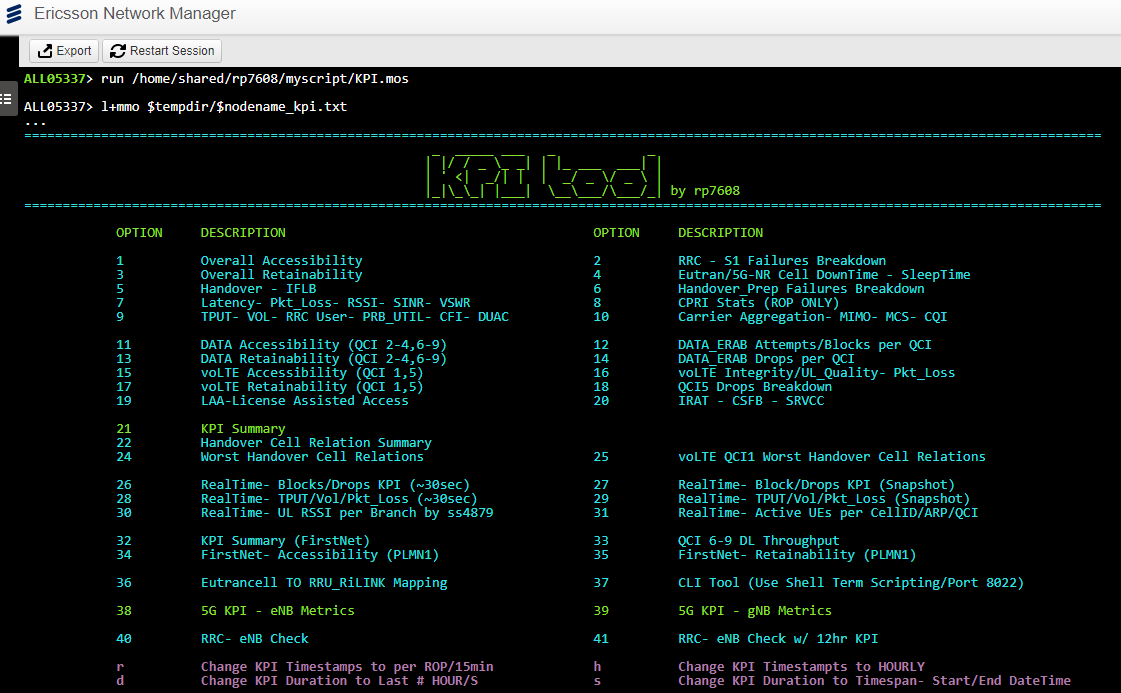

### Connecting to ENM Server: http://ej.web.att.com:8080/3P_Blog/CLIweb/CLIcon.html
   

### ENM CLI Command User Set Up:

#### Log Into ENM Server

Step 1: Open Putty
Step 2:  Input the following settings. Note: Host Name will always be vtc2e11enm-proxy-nesa-aln.web.att.com, regardless of the desired market.
 
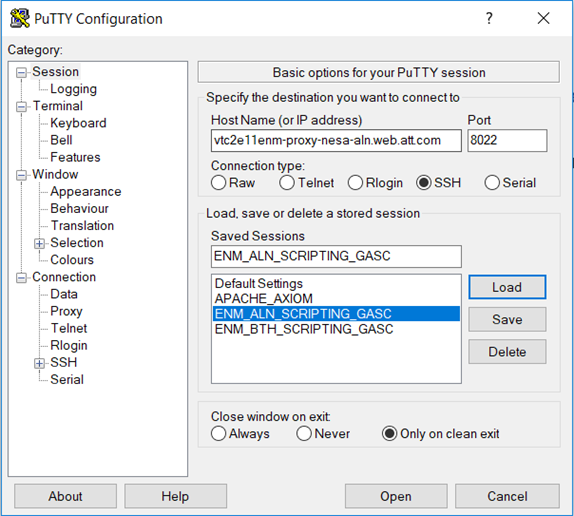

Step 3: Press Open.
Step 4: When prompted, enter your ATTID. Press enter.
Step 5: When prompted, enter the code from your RSA token. Note that you will not see any characters on the command line. Press enter.
Step 6: When prompted for neID, enter the code for your corresponding market appended with ‘enm’.
 
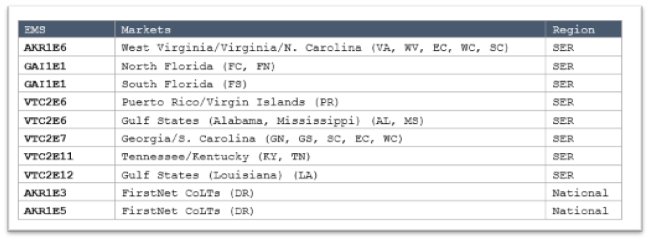

*Example input for GA/SC Market:*

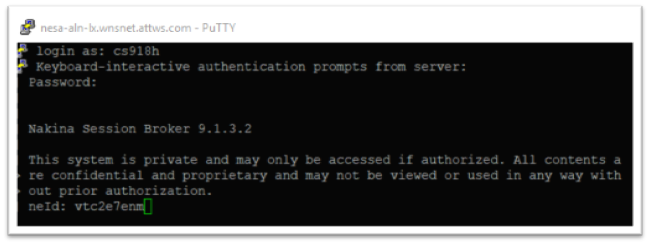

Press Enter.


#### Create Script to Run ENM Commands

Step 1: Type the following code into the command line, then press enter.

                    vim commandRunner.py
                    
Step 2: Press i. You will now be in insert mode.

 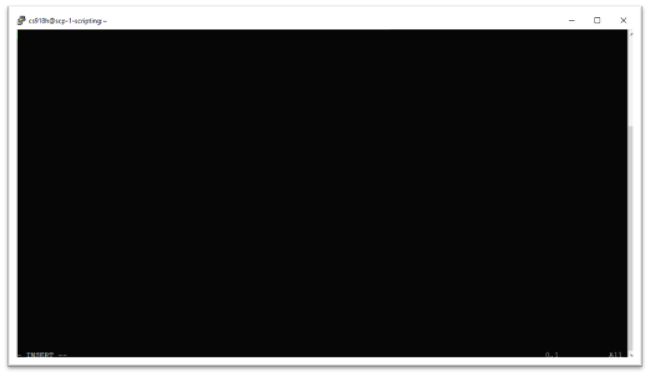

(Insert will be printed at the bottom of your screen)

Step 4: Copy the following code. Then paste it into the file by right clicking on your mouse.

*#!/usr/bin/python
<br>import sys
<br>import enmscripting
<br>cmd = ' '.join(sys.argv[1:])
<br>session = enmscripting.open()
<br>terminal = session.terminal()
<br>response = terminal.execute(cmd)
<br>for line in response.get_output():
 	<br>print(line)
<br>print('Command Success: ' + str(response.is_command_result_available()))
<br>enmscripting.close(session)*


Step 5: Press esc button. Then type :wq! . Press enter. This is saving your file.

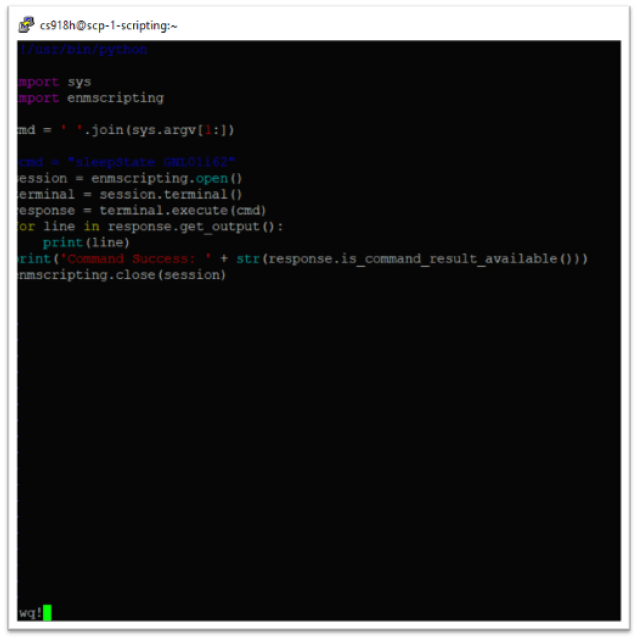

Step 6: Type chmod +x commandRunner.py into your command line and press enter. This is giving the file read access.